15.5


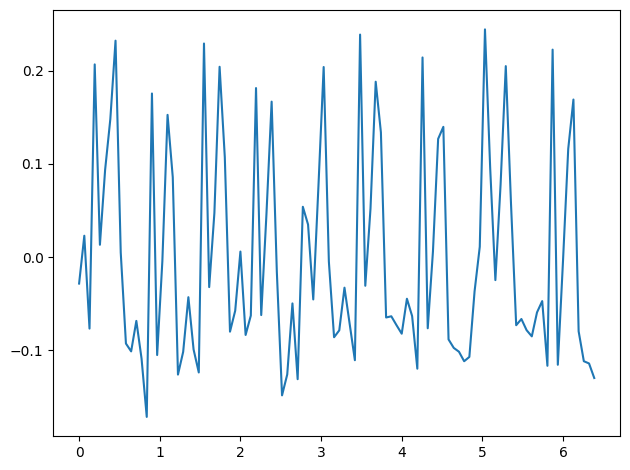

[-0.02834769  0.02297352 -0.07665539  0.20677956  0.01325776  0.09372438
  0.14809217  0.23224439  0.00503895 -0.0926865  -0.10110869 -0.06841221
 -0.10878268 -0.17139976  0.17556961 -0.10502232 -0.00429838  0.15264848
  0.08575903 -0.12598951 -0.10158214 -0.042966   -0.09905178 -0.12371641
  0.22919293 -0.03214624  0.04746215  0.20422592  0.10735725 -0.07993497
 -0.05745279  0.00598338 -0.08347207 -0.06269614  0.18139769 -0.06214451
  0.04568017  0.16683031 -0.01577968 -0.14827781 -0.12583137 -0.04964251
 -0.13094255  0.05401468  0.03496031 -0.04538164  0.07671407  0.20398218
 -0.00482512 -0.08593068 -0.07852573 -0.03276421 -0.07175828 -0.11057521
  0.23876435 -0.03071345  0.05206306  0.18820832  0.13387552 -0.06474873
 -0.06345066 -0.0729964  -0.08213963 -0.0446295  -0.06321854 -0.11967036
  0.21423316 -0.0763145   0.00584997  0.12685541  0.13979316 -0.08828469
 -0.09736554 -0.1014752  -0.11167545 -0.10706034 -0.03675147  0.01110776
  0.2443584   0.09583286 -0.02463814  0.07778139  0

In [31]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft


def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ECG = signals[:,0]
        return ECG, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def plot(data, samp_rate):
    """Creates a plot. F(t)"""
    time = np.arange(0, len(data) / samp_rate, 1 / samp_rate)

    plt.plot(time, data)
    plt.tight_layout()
    plt.show()


def find_Rpeaks(ekg_signal, frekvence_vzorkovani, okenni_delka=50):
    r_piky = []
    cas = []

    for i in range(len(ekg_signal) - okenni_delka):
        okenni_signal = ekg_signal[i:i + okenni_delka]

        # Nalezení pozice maximální hodnoty v okně
        max_pozice = i + np.argmax(okenni_signal)

        # Přidání pozice R píku a odpovídajícího času
        if max_pozice not in r_piky:
            r_piky.append(max_pozice)
            cas.append(max_pozice / frekvence_vzorkovani)
        else:
            continue

    return r_piky, cas


database = 'Database/drive05'
ECGnative, fields = load_data(database)
samp_rate = fields['fs']
print(samp_rate)
#crapped data for rewiev
ecg_data = np.array(ECGnative[:100])

cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
plot(ecg_edit_fft, samp_rate)
print(ecg_edit_fft)

Rpeaks = find_Rpeaks(ecg_edit_fft, samp_rate)
print(Rpeaks)



In [4]:
def detect_peaks(X, N=5, area=3, rthreshold=50, pthreshold=90, do_plot=False):
    WS = (N//2)+1
    f, t, Zxx = scipy.signal.stft(X, nperseg=N, noverlap=0)
    Zxx = np.abs(Zxx).reshape(-1, WS)
    wmax = np.max(Zxx, axis=1)
    thresholdP = np.percentile(X, pthreshold)
    peaks = []
    for base in intervals.astype(int):
        if base >= X.size:
            continue
        if base > WS + area:
            base = base-WS-area
        end = base + N + area*2
        window = X[base:end]
        imax = np.max(window)
        if imax > thresholdP:
            peakT = base + np.argmax(window)
            if peakT in peaks:
                continue
            peaks.append(peakT)